# Dataloader

The content of this notebook can be found in the file `preprocessing.py`. This notebook is only for understanding the code.

In [1]:
import os
from os.path import join

from glob import glob
from natsort import natsorted

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch

from PIL import Image, ImageOps

import numpy as np
import shutil

#### Project Parameters

In [2]:
PROJECT_DIR = os.getcwd()
os.chdir(PROJECT_DIR)
DATA_DIR = "../04-Data"

#### Locate images and targets

In [3]:
train_targets_path = os.path.join(DATA_DIR,"patches_1024", 'train_targets_patches')
train_images_path = os.path.join(DATA_DIR,"patches_1024",'train_images_patches')

train_images_list = glob(join(train_images_path, "**", "*.png"),recursive=True)
train_images_list = natsorted(train_images_list, key=lambda y: y.lower())
train_targets_list = glob(join(train_targets_path, "**", "*.txt"),recursive=True)
train_targets_list = natsorted(train_targets_list, key=lambda y: y.lower())

val_targets_path = os.path.join(DATA_DIR,"patches_1024",'val_targets_patches')
val_images_path = os.path.join(DATA_DIR,'patches_1024', "val_images_patches")

val_images_list = glob(join(val_images_path, "**", "*.png"),recursive=True)
val_images_list = natsorted(val_images_list, key=lambda y: y.lower())
val_targets_list = glob(join(val_targets_path, "**", "*.txt"),recursive=True)
val_targets_list = natsorted(val_targets_list, key=lambda y: y.lower())

test_targets_path = os.path.join(DATA_DIR,"patches_1024",'test_targets_patches')
test_images_path = os.path.join(DATA_DIR,'patches_1024', "test_images_patches")

test_images_list = glob(join(test_images_path, "**", "*.png"),recursive=True)
test_images_list = natsorted(test_images_list, key=lambda y: y.lower())
test_targets_list = glob(join(test_targets_path, "**", "*.txt"),recursive=True)
test_targets_list = natsorted(test_targets_list, key=lambda y: y.lower())

#### Dataset class

In [4]:
class ToTensor(object):
    def __call__(self, image):
        image = np.array(image)
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        image = image.float()/255.0        
        
        return image

In [8]:
class DotaDataset(Dataset):
    def __init__(self, images_path, targets_path, transform = ToTensor()):
        
        self.images_path = images_path
        self.targets_path = targets_path
        self.transform = transform
  
        self.class_to_idx = {
               "ship" : 0, 
               "storage-tank" : 1, 
               "baseball-diamond" : 2, 
               "tennis-court" : 3, 
               "basketball-court" : 4, 
               "ground-track-field" : 5, 
               "bridge" : 6, 
               "large-vehicle" : 7, 
               "small-vehicle" : 8, 
               "helicopter" : 9, 
               "swimming-pool" : 10, 
               "roundabout" : 11, 
               "soccer-ball-field" : 12, 
               "plane" : 13, 
               "harbor" : 14,
               "container-crane" : 15,
               "no_object": 16}

        self.colors = {
            'container-crane': 'blue',
            'ship': 'red',
            'storage-tank': 'green',
            'baseball-diamond': 'yellow',
            'tennis-court': 'purple',
            'basketball-court': 'orange',
            'ground-track-field': 'pink',
            'bridge': 'turquoise',
            'large-vehicle': 'brown',
            'small-vehicle': 'azure',
            'helicopter': 'lime',
            'swimming-pool': 'cyan',
            'roundabout': 'magenta',
            'soccer-ball-field': 'gold',
            'plane': 'lime',
            'harbor': 'indigo',
            'no_object': 'black'}

    def __len__(self):
        return(len(self.images_path))

    def __getitem__(self, idx):
        image = Image.open(self.images_path[idx])
        target = self.targets_path[idx]
        if self.transform:
            image = self.transform(image)

        hbb=self.read_txt(self.targets_path[idx])
        hbb=self.extract_hbb(hbb)

        boxes = []
        labels = []

        # What happens if boxes and labels are empty lists? Does this work during training?
        for box in hbb:
            xmin, xmax, ymin, ymax, label = box['x_min'], box['x_max'], box['y_min'], box['y_max'], box['label']
            boxes.append([xmin, ymin, xmax, ymax])
            id = self.class_to_idx[label]
            labels.append(id)
        
        if len(boxes) == 0:
            boxes.append([0, 0, 0, 0])  # Dummy box
            labels.append(-1)            # Dummy label
        
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        targets = {
        "boxes": boxes,
        "labels": labels}
        
        return image, targets

    def read_txt(self, path):
        '''
        Reads a text file
        Returns a list of lines in the text file
        path: Path to text file
        '''
        with open(path, 'r') as file:
            lines = file.readlines()
        return lines

    def get_image_path(self, idx):
        '''
        Returns image path at the index
        idx: Index of image path to return
        '''
        return self.images_path[idx]

    def get_unique_labels(self, target_path):
        '''
        Returns the unique labels of targets in an image
        taget_path: Path to the target
        '''
        unique_names = set()
        txt_file=self.read_txt(target_path)
        hbb_list=self.extract_hbb(txt_file)
        for d in hbb_list:
            name = d["label"]
            unique_names.add(name)
        unique_names=list(unique_names)
        return unique_names

    def create_custom_legend(self, labels,axes):
        '''
        Creates a legend for the objects in an image
        labels: Labels of the objects
        '''
        bbox_to_anchor=(1.04, 1)
        handles = []
        color_list=[]
        for label in labels:
            color_list.append(self.colors[label])
        for color, label in zip(color_list, labels):
            handle = Rectangle((0, 0), 1, 1, color=color, label=label)
            handles.append(handle)
        axes.legend(handles=handles,  loc="upper left", bbox_to_anchor=bbox_to_anchor)

    def extract_hbb(self, pxl_coordinates: list):
        '''
        Returns a dictionary of bounding box coordinates from a text file
        pxl_coordinates: List of bounding box strings
        '''
        bounding_boxes=[]
        for location in pxl_coordinates:
            parts = location.strip().split()
            x_min=float(parts[0])
            y_min=float(parts[1])
            x_max=float(parts[4])
            y_max=float(parts[5])
            class_label=parts[8]
            bounding_boxes.append({'label':class_label,
                                  'x_min':x_min,
                                  'y_min':y_min,
                                  'x_max':x_max,
                                  'y_max':y_max})
        return bounding_boxes

    def get_number_of_instances(self, target_path):
        '''
        Returns the number of objects in an image.
        target_path: Path to the target of the image
        '''
        unique_names=self.get_unique_labels(target_path)
        txt_file=self.read_txt(target_path)
        hbb_list=self.extract_hbb(txt_file)
        dic={item: 0  for item in unique_names}
        for box in hbb_list:
            if box["label"] in dic.keys():
                dic[box["label"]]+=1
        return dic

    def visualize(self, idx):
        '''
        Shows the image at the index and the objects 
        idx: Index of image to display
        '''
        print("Image path: " + self.images_path[idx])
        print("Target path: " + self.targets_path[idx])
    
        image = Image.open(self.images_path[idx])
  #      if self.transform:
   #         image = self.transform(image)
    #    image = image.permute(1, 2, 0).numpy()  # Change order to HxWxC
    
        fig, ax = plt.subplots()
        ax.imshow(image)
        hbb=self.read_txt(self.targets_path[idx])
        hbb=self.extract_hbb(hbb)
        for box in hbb:
            if box['label'] in self.colors:
                color=self.colors[box['label']]
            xmin, xmax, ymin, ymax, label = box['x_min'], box['x_max'], box['y_min'], box['y_max'], box['label']
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
        self.create_custom_legend(self.get_unique_labels(self.targets_path[idx]),ax)
        ax.axis('off')
        plt.show()
        example=self.get_number_of_instances(self.targets_path[idx])
        for key, value in example.items():
            print(f"{key}: {value}")
        print("\n")

#### Create Dataset

In [9]:
train_set = DotaDataset(train_images_list, train_targets_list)
val_set = DotaDataset(val_images_list, val_targets_list)
test_set = DotaDataset(test_images_list, test_targets_list)

#### Visualization

Image path: ../04-Data/patches_1024/test_images_patches/P0816/P0816_1024_OL-0_x-0_y-0.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0816/P0816_1024_OL-0_x-0_y-0.txt


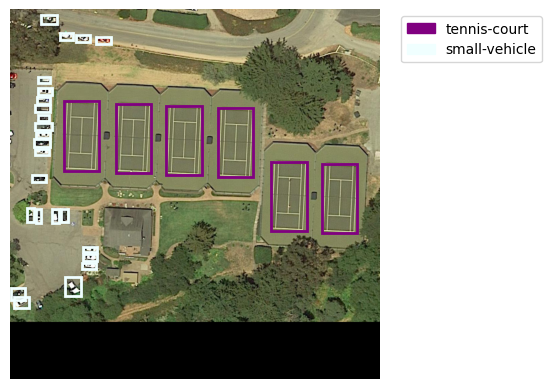

tennis-court: 6
small-vehicle: 24


Image path: ../04-Data/patches_1024/test_images_patches/P0816/P0816_1024_OL-0_x-1024_y-0.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0816/P0816_1024_OL-0_x-1024_y-0.txt


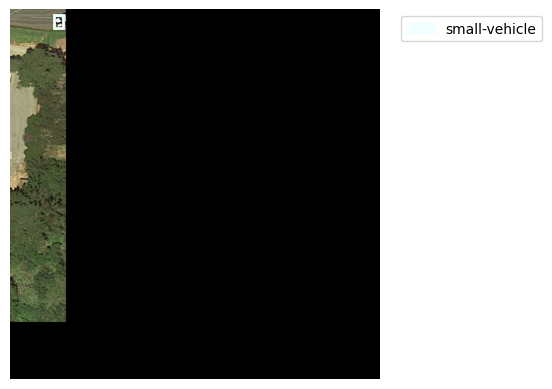

small-vehicle: 1


Image path: ../04-Data/patches_1024/test_images_patches/P0822/P0822_1024_OL-0_x-0_y-0.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0822/P0822_1024_OL-0_x-0_y-0.txt


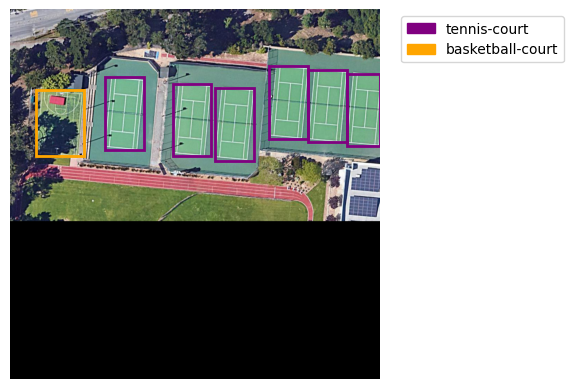

tennis-court: 6
basketball-court: 1


Image path: ../04-Data/patches_1024/test_images_patches/P0822/P0822_1024_OL-0_x-1024_y-0.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0822/P0822_1024_OL-0_x-1024_y-0.txt


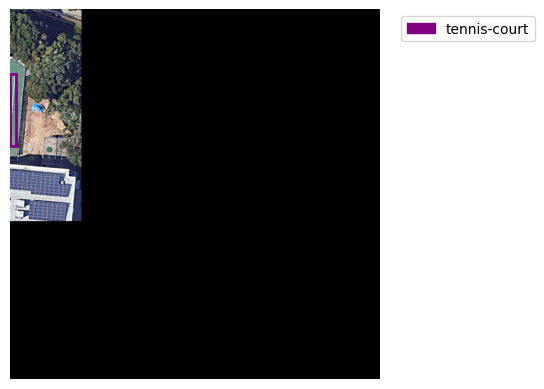

tennis-court: 1


Image path: ../04-Data/patches_1024/test_images_patches/P0841/P0841_1024_OL-0_x-0_y-0.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0841/P0841_1024_OL-0_x-0_y-0.txt


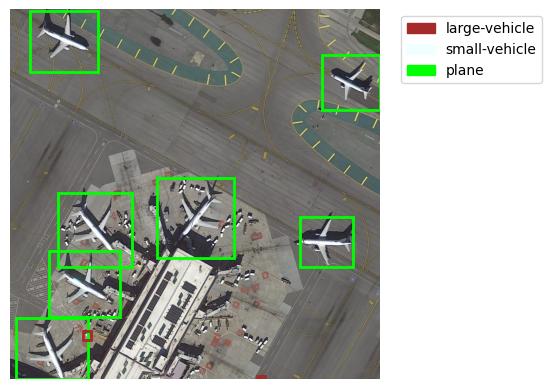

large-vehicle: 2
small-vehicle: 1
plane: 7


Image path: ../04-Data/patches_1024/test_images_patches/P0841/P0841_1024_OL-0_x-0_y-1024.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0841/P0841_1024_OL-0_x-0_y-1024.txt


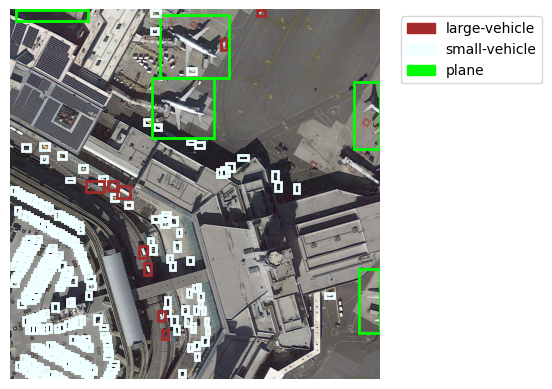

large-vehicle: 9
small-vehicle: 282
plane: 5


Image path: ../04-Data/patches_1024/test_images_patches/P0841/P0841_1024_OL-0_x-0_y-2048.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0841/P0841_1024_OL-0_x-0_y-2048.txt


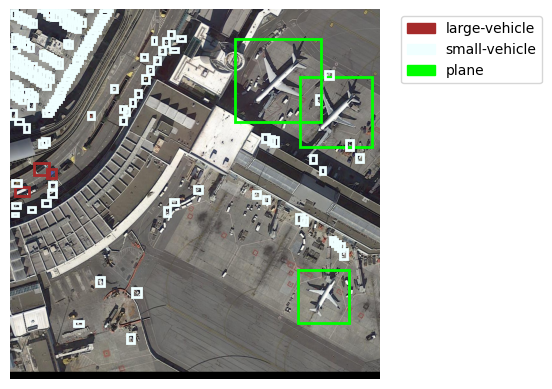

large-vehicle: 3
small-vehicle: 169
plane: 3


Image path: ../04-Data/patches_1024/test_images_patches/P0841/P0841_1024_OL-0_x-1024_y-0.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0841/P0841_1024_OL-0_x-1024_y-0.txt


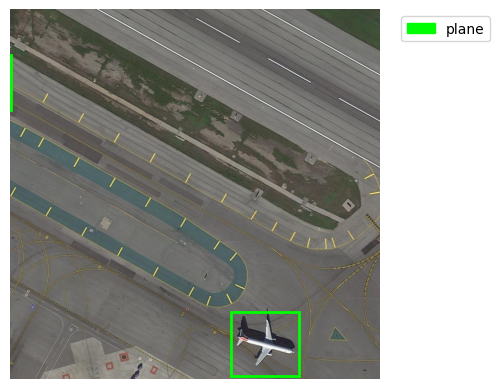

plane: 2


Image path: ../04-Data/patches_1024/test_images_patches/P0841/P0841_1024_OL-0_x-1024_y-1024.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0841/P0841_1024_OL-0_x-1024_y-1024.txt


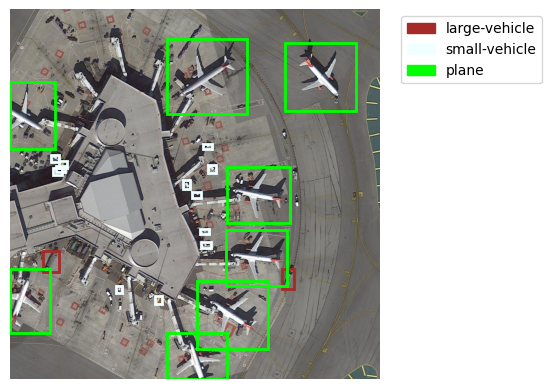

large-vehicle: 2
small-vehicle: 12
plane: 8


Image path: ../04-Data/patches_1024/test_images_patches/P0841/P0841_1024_OL-0_x-1024_y-2048.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0841/P0841_1024_OL-0_x-1024_y-2048.txt


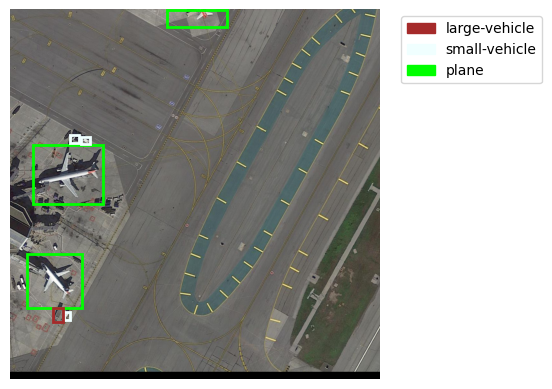

large-vehicle: 1
small-vehicle: 3
plane: 3


Image path: ../04-Data/patches_1024/test_images_patches/P0841/P0841_1024_OL-0_x-2048_y-0.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0841/P0841_1024_OL-0_x-2048_y-0.txt


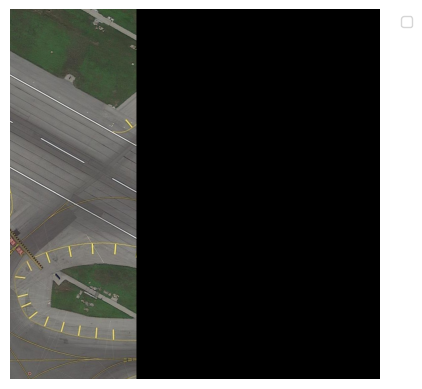



Image path: ../04-Data/patches_1024/test_images_patches/P0841/P0841_1024_OL-0_x-2048_y-1024.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0841/P0841_1024_OL-0_x-2048_y-1024.txt


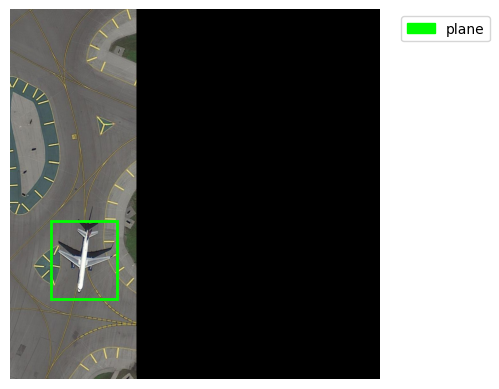

plane: 1


Image path: ../04-Data/patches_1024/test_images_patches/P0841/P0841_1024_OL-0_x-2048_y-2048.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0841/P0841_1024_OL-0_x-2048_y-2048.txt


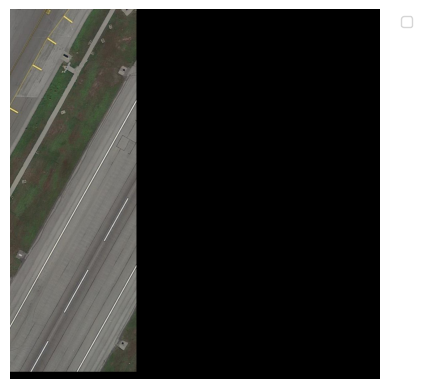



Image path: ../04-Data/patches_1024/test_images_patches/P0858/P0858_1024_OL-0_x-0_y-0.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0858/P0858_1024_OL-0_x-0_y-0.txt


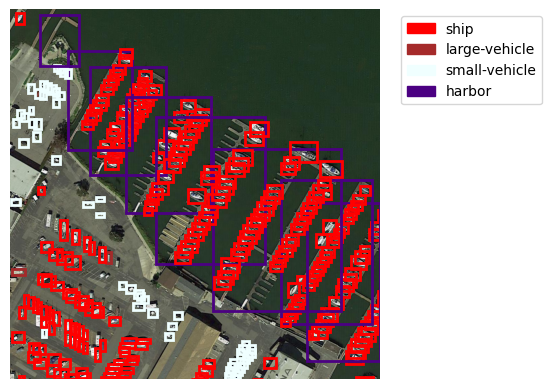

ship: 249
large-vehicle: 2
small-vehicle: 55
harbor: 8


Image path: ../04-Data/patches_1024/test_images_patches/P0858/P0858_1024_OL-0_x-0_y-1024.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0858/P0858_1024_OL-0_x-0_y-1024.txt


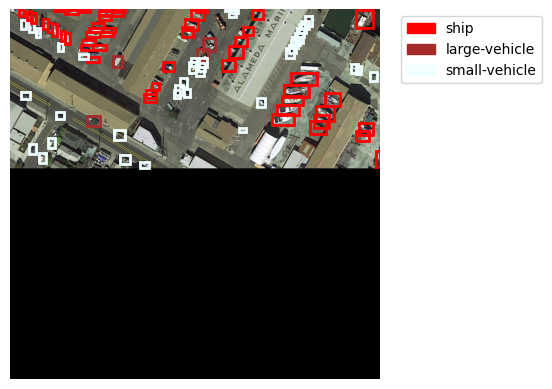

ship: 51
large-vehicle: 4
small-vehicle: 39


Image path: ../04-Data/patches_1024/test_images_patches/P0858/P0858_1024_OL-0_x-1024_y-0.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0858/P0858_1024_OL-0_x-1024_y-0.txt


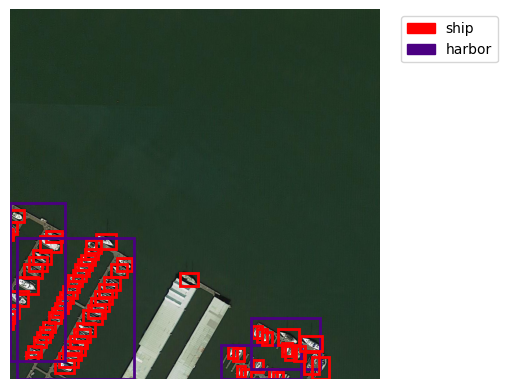

ship: 67
harbor: 4


Image path: ../04-Data/patches_1024/test_images_patches/P0858/P0858_1024_OL-0_x-1024_y-1024.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0858/P0858_1024_OL-0_x-1024_y-1024.txt


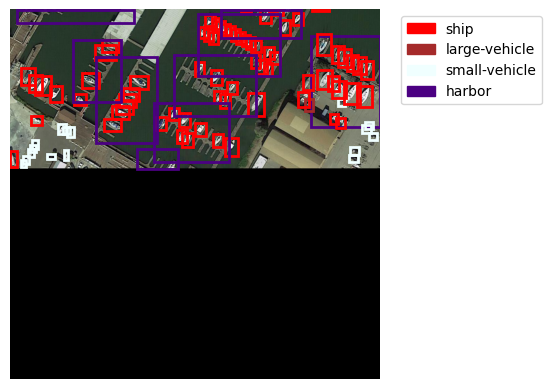

ship: 70
large-vehicle: 1
small-vehicle: 16
harbor: 9


Image path: ../04-Data/patches_1024/test_images_patches/P0858/P0858_1024_OL-0_x-2048_y-0.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0858/P0858_1024_OL-0_x-2048_y-0.txt


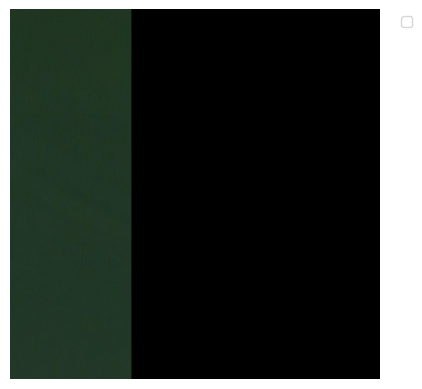



Image path: ../04-Data/patches_1024/test_images_patches/P0858/P0858_1024_OL-0_x-2048_y-1024.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0858/P0858_1024_OL-0_x-2048_y-1024.txt


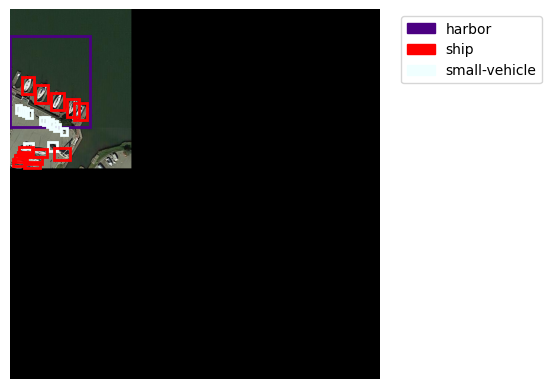

harbor: 1
ship: 13
small-vehicle: 12


Image path: ../04-Data/patches_1024/test_images_patches/P0864/P0864_1024_OL-0_x-0_y-0.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0864/P0864_1024_OL-0_x-0_y-0.txt


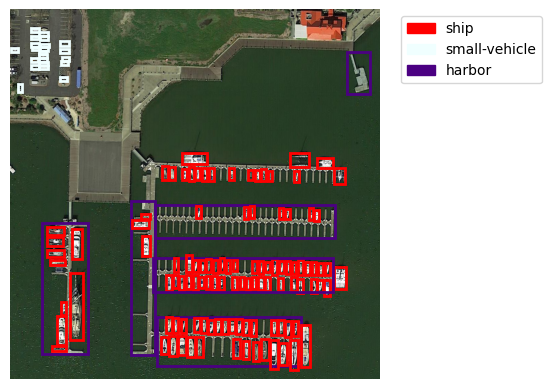

ship: 108
small-vehicle: 22
harbor: 6


Image path: ../04-Data/patches_1024/test_images_patches/P0864/P0864_1024_OL-0_x-0_y-1024.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0864/P0864_1024_OL-0_x-0_y-1024.txt


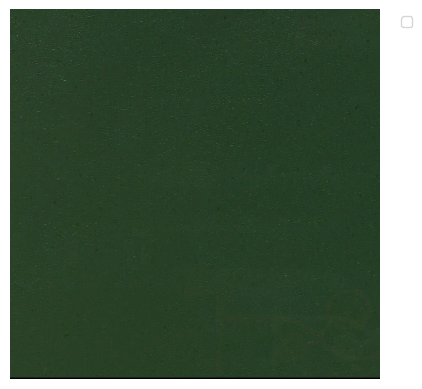



Image path: ../04-Data/patches_1024/test_images_patches/P0864/P0864_1024_OL-0_x-1024_y-0.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0864/P0864_1024_OL-0_x-1024_y-0.txt


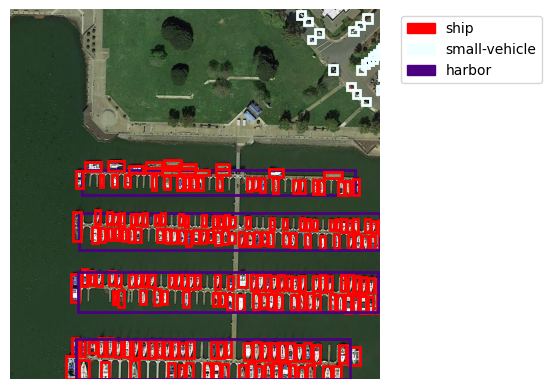

ship: 211
small-vehicle: 22
harbor: 4


Image path: ../04-Data/patches_1024/test_images_patches/P0864/P0864_1024_OL-0_x-1024_y-1024.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0864/P0864_1024_OL-0_x-1024_y-1024.txt


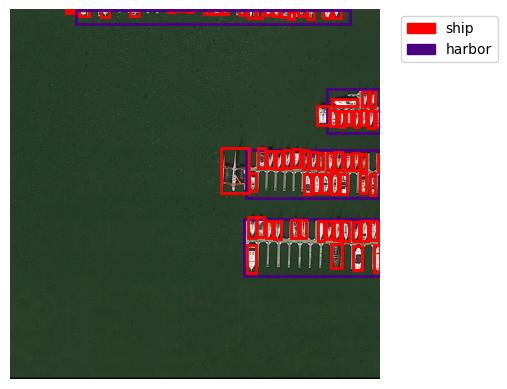

ship: 74
harbor: 4


Image path: ../04-Data/patches_1024/test_images_patches/P0864/P0864_1024_OL-0_x-2048_y-0.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0864/P0864_1024_OL-0_x-2048_y-0.txt


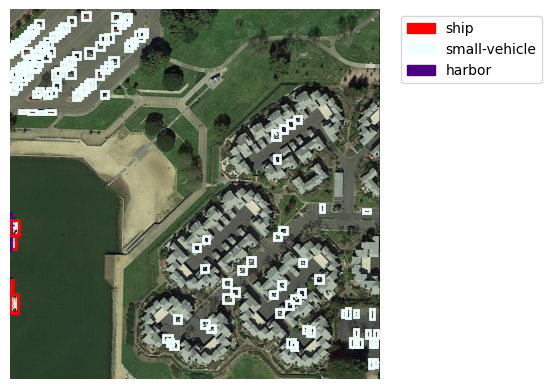

ship: 4
small-vehicle: 132
harbor: 1


Image path: ../04-Data/patches_1024/test_images_patches/P0864/P0864_1024_OL-0_x-2048_y-1024.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0864/P0864_1024_OL-0_x-2048_y-1024.txt


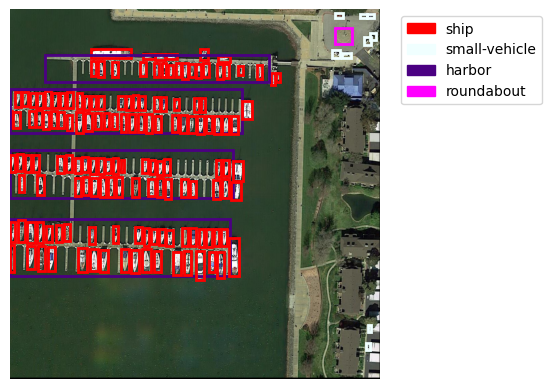

ship: 146
small-vehicle: 9
harbor: 4
roundabout: 1


Image path: ../04-Data/patches_1024/test_images_patches/P0882/P0882_1024_OL-0_x-0_y-0.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0882/P0882_1024_OL-0_x-0_y-0.txt


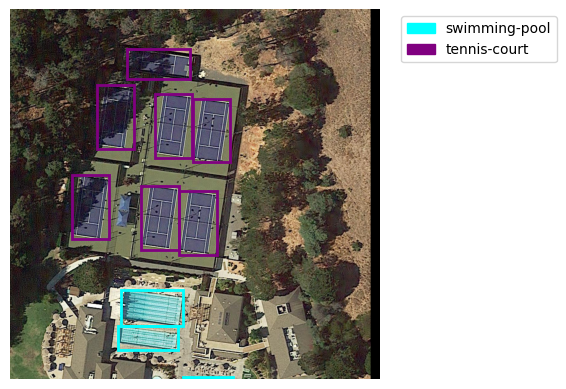

swimming-pool: 3
tennis-court: 7


Image path: ../04-Data/patches_1024/test_images_patches/P0882/P0882_1024_OL-0_x-0_y-1024.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0882/P0882_1024_OL-0_x-0_y-1024.txt


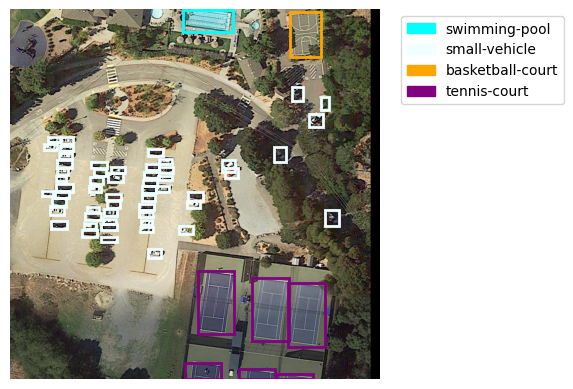

swimming-pool: 1
small-vehicle: 55
basketball-court: 1
tennis-court: 6


Image path: ../04-Data/patches_1024/test_images_patches/P0882/P0882_1024_OL-0_x-0_y-2048.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0882/P0882_1024_OL-0_x-0_y-2048.txt


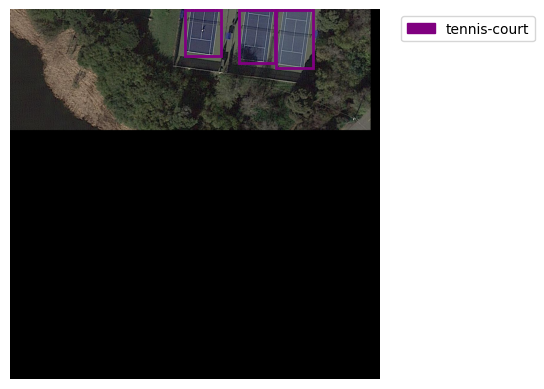

tennis-court: 3


Image path: ../04-Data/patches_1024/test_images_patches/P0897/P0897_1024_OL-0_x-0_y-0.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0897/P0897_1024_OL-0_x-0_y-0.txt


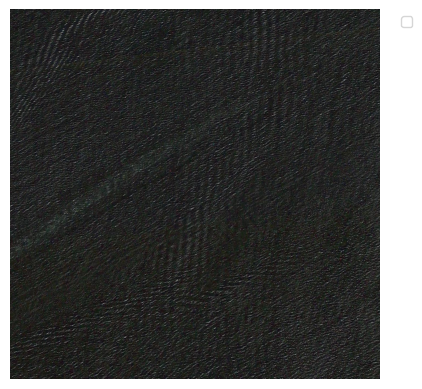



Image path: ../04-Data/patches_1024/test_images_patches/P0897/P0897_1024_OL-0_x-0_y-1024.png
Target path: ../04-Data/patches_1024/test_targets_patches/P0897/P0897_1024_OL-0_x-0_y-1024.txt


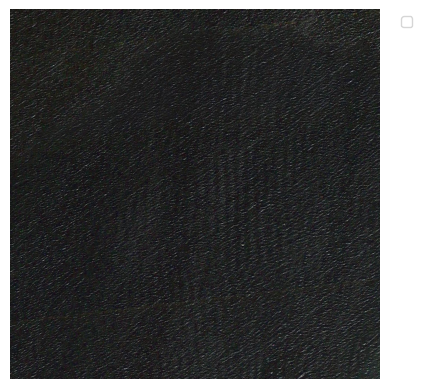

In [10]:
for i in range(280,310):
    test_set.visualize(i)

#### Sanity Check

In [71]:
def perform_sanity_check(dataset):
    unique_img_shapes = set()
    different_image_paths = []
    
    for i, (img, boxes, labels) in enumerate(dataset):
        img_shape = img.shape
        if img_shape not in unique_img_shapes:
            unique_img_shapes.add(img_shape)
            different_image_paths.append(train_set.get_image_path(i))
    
    print("Unique image shapes:")
    for shape in unique_img_shapes:
        print(shape)
    print("Images with different image shape:")
    for path in different_image_paths:
        print(path)

In [72]:
print("Sanity check train set:")
#perform_sanity_check(train_set)
print("Sanity check val set:")
#perform_sanity_check(val_set)

Sanity check train set:
Sanity check val set:


#### DataLoader

Some of the images do not contain bounding boxes. In order for the DataLoader to work, either these images have to be excluded or a dummy bounding box and a ignore class is introduced. Here the second option was chosen.

The DataLoader returns a tuple containing two lists, each with a length equal to the batch size:

1. **List of Images**: This list consists of PyTorch tensors, each representing an image. These tensors have the shape `[C, H, W]`, where:
   - `C` is the number of color channels (e.g., 3 for RGB images),
   - `H` is the height of the image,
   - `W` is the width of the image.

2. **List of Targets**: This list contains dictionaries, with each dictionary corresponding to an image in the batch. Each dictionary includes:
   - **"boxes"**: A tensor with shape `[num_objects, 4]`, where `num_objects` is the number of bounding boxes. Each bounding box is represented by its coordinates in the format `[xmin, ymin, xmax, ymax]`.
   - **"labels"**: A tensor with shape `[num_objects]`, containing class labels for each bounding box.

This structure allows the DataLoader to handle variable-sized data efficiently, supporting tasks such as object detection where the number of objects per image can differ.


In [73]:
def collate_fn(batch):
    '''
    In object detection bounding box targets have different shapes depending on the number of bounding boxes per image.
    Therefore the creation of batches needs to be done manaully
    '''
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

In [75]:
trainloader = DataLoader(train_set, batch_size = 32, shuffle = True, collate_fn = collate_fn)
valloader = DataLoader(val_set, batch_size = 32, shuffle = False, collate_fn = collate_fn)

In [14]:
from ultralytics import YOLO
model = YOLO("../best.pt")

In [15]:
image = "../04-Data/patches/train_images_patches/P0209/P0209_1024_OL-256_x-3072_y-0.png"

In [16]:
results = model([image])
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="hello.jpg")  # save to disk


0: 1024x1024 12 planes, 403.9ms
Speed: 7.7ms preprocess, 403.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)
